In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sentence_transformers import SentenceTransformer, util
import torch
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [89]:
raw_train_data = pd.read_csv('C:\\Users\\xu741\\Desktop\\IML\\a1\\a3\\raw-data\\train.csv')
raw_test_data = pd.read_csv('C:\\Users\\xu741\\Desktop\\IML\\a1\\a3\\raw-data\\test.csv')
raw_valid_data = pd.read_csv('C:\\Users\\xu741\\Desktop\\IML\\a1\\a3\\raw-data\\valid.csv')

sentenceTransformer = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

Now we embed the data with sentencecTransformer

In [90]:
# # repalce nan with mean value 
# raw_train_data.fillna(raw_train_data.mean(),inplace=True)

# # convert requirements and role column into bag-of-words representation 
# raw_train_data['requirements_and_role'].fillna('', inplace=True)

# sepearte labeled data and unlableled

bins = [-float('inf'), 0, 1, 2, 3, 4, 5, 6, 7, 8, float('inf')]
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

raw_train_data['salary_bin_cat'] = pd.cut(raw_train_data['salary_bin'], bins=bins, labels=labels)
raw_valid_data['salary_bin_cat'] = pd.cut(raw_valid_data['salary_bin'], bins=bins, labels=labels)

raw_train_X = raw_train_data['requirements_and_role']
raw_valid_X = raw_valid_data['requirements_and_role']

# embedded_raw_train_X = sentenceTransformer.encode(raw_train_X)
# embedded_raw_valid_X = sentenceTransformer.encode(raw_valid_X)
# embedded_raw_test_X = sentenceTransformer.encode(raw_test_X)
embedded_raw_train_X = np.load('C:\\Users\\xu741\\Desktop\\IML\\a1\\a3\\raw-data\\embedded_raw_train_X.npy')
embedded_raw_valid_X = np.load('C:\\Users\\xu741\\Desktop\\IML\\a1\\a3\\raw-data\\embedded_raw_valid_X.npy')
embedded_raw_test_X = np.load('C:\\Users\\xu741\\Desktop\\IML\\a1\\a3\\raw-data\\embedded_raw_test_X.npy')


# get categorical data 
salary_bin_raw_train = raw_train_data['salary_bin_cat']
salary_bin_raw_valid = raw_valid_data['salary_bin_cat']

# get Target labels and untarget labels for train data 
labeled_train_data_y = salary_bin_raw_train[:8000]
unlabeled_train_data_y = salary_bin_raw_train[-5902:]
labeled_embedded_raw_train_X = embedded_raw_train_X[:8000]
unlabeled_embedded_raw_train_X = embedded_raw_train_X[-5902:]


X_valid_raw = raw_valid_data['requirements_and_role']
y_valid = salary_bin_raw_valid

Define functions for replace synonyms for embedde data

In [91]:
def replace_synonyms(embedded_text, p=0.1):
    augmented_text = []
    augmented_features = []
    for vec in embedded_text:
        if np.random.rand() < p:
            # Find top k+1 most similar vectors and exclude the original vector
            similar_vecs = get_nearest_neighbors(torch.tensor(vec), torch.tensor(embedded_text), k=2)
            if len(similar_vecs) > 0:
                candidates = [sv['embedding'].numpy() for sv in similar_vecs if not np.array_equal(sv['embedding'].numpy(), vec)]
                if len(candidates) > 0:
                    new_vec = np.random.randn(*vec.shape)
                    augmented_text.append(np.array(candidates)[np.random.randint(len(candidates))] + new_vec)
                    augmented_features.append(vec)
                else:
                    augmented_text.append(vec)
                    augmented_features.append(vec)
            else:
                augmented_text.append(vec)
                augmented_features.append(vec)
        else:
            augmented_text.append(vec)
            augmented_features.append(vec)
    return np.array(augmented_text), np.array(augmented_features)

def get_nearest_neighbors(vec, candidates, k=10):
    cosine_scores = util.pytorch_cos_sim(vec, candidates)[0]
    topk = torch.topk(cosine_scores, k=k+1)
    return [{'embedding': candidates[idx], 'score': score} for idx, score in zip(topk.indices.tolist(), topk.values.tolist())]

Replace some data, then add into the total data

In [92]:
# Augment the labeled training data using synonym replacement
print(labeled_embedded_raw_train_X.shape)
# augmented_train_data_X = replace_synonyms(labeled_embedded_raw_train_X)
augmented_train_data_X =  np.load('C:\\Users\\xu741\\Desktop\\IML\\a1\\a3\\raw-data\\augmented_train_data_X.npy')
augmented_train_data_y = labeled_train_data_y

(8000, 768)


In [93]:
# np.save('augmented_train_data_X.npy', augmented_train_data_X)

# files.download('augmented_train_data_X.npy')
print(augmented_train_data_X[0].shape)
print(labeled_embedded_raw_train_X.shape)
print(np.array_equal(augmented_train_data_X[0],labeled_embedded_raw_train_X))
diff = np.abs(augmented_train_data_X[0] - labeled_embedded_raw_train_X)
print("Total difference:", np.sum(diff))
print("Mean difference:", np.mean(diff))

(8000, 768)
(8000, 768)
False
Total difference: 497467.58310141426
Mean difference: 0.08096803110374581


Plot graph to show the difference between original and augmented data

In [ ]:
# Plot histogram of differences
plt.hist(diff.flatten(), bins=50)
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.title("Histogram of differences between original and augmented data")
plt.show()

In [94]:
# Combine the original and augmented training data

combined_train_data_X = np.concatenate((labeled_embedded_raw_train_X, augmented_train_data_X[0]), axis=0)
combined_train_data_y = np.concatenate((labeled_train_data_y, augmented_train_data_y), axis=0)

Scaler the dataset

In [95]:
print(combined_train_data_X.shape)
print(embedded_raw_valid_X.shape)

scaler = StandardScaler()
combined_train_data_X = scaler.fit_transform(combined_train_data_X)
X_valid_embedding = scaler.transform(embedded_raw_valid_X)
X_test_embedding = scaler.transform(embedded_raw_test_X)
unlabeled_embedded_raw_train_X = scaler.transform(unlabeled_embedded_raw_train_X)

combined_train_data_X = np.hstack((np.ones((combined_train_data_X.shape[0], 1)), combined_train_data_X))
X_valid_embedding = np.hstack((np.ones((X_valid_embedding.shape[0], 1)), X_valid_embedding))
X_test_embedding = np.hstack((np.ones((X_test_embedding.shape[0], 1)), X_test_embedding))
unlabeled_embedded_raw_train_X = np.hstack((np.ones((unlabeled_embedded_raw_train_X.shape[0], 1)), unlabeled_embedded_raw_train_X))


(16000, 768)
(1737, 768)


Define some models

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
lr = LogisticRegression(max_iter=5000)
knn = KNeighborsClassifier()
gnb = GaussianNB()
rf = RandomForestClassifier()
svc = SVC()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models_optimize = {
    'lr': {
        'estimator': lr,
        'param_grid': {
            'penalty': ['l2','none'],
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
            'max_iter': [50, 100, 200, 500, 1000]
        }
    },
    'gnb': {
        'estimator': gnb,
        'param_grid': {
            'var_smoothing': np.logspace(-15, -5, 200)
        }
    },
    'knn': {
        'estimator': knn,
        'param_grid': {
            'n_neighbors': range(1,20),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'rf': {
        'estimator': rf,
        'param_grid': {
            'n_estimators': [50, 100, 200, 500, 1000],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [None, 5, 10, 20, 30],
            'min_samples_leaf': [1, 2, 4, 8]
        }
    },
    'svc': {
        'estimator': svc,
        'param_grid': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'kernel': ['linear','poly', 'rbf', 'sigmoid'],
            'degree': [0, 1, 2, 3, 4, 5, 6],
            'probability': [True]
        }
    }
}

Tune the hyperparameters using random search

In [97]:
from sklearn.model_selection import RandomizedSearchCV

for model_name, model_data in models_optimize.items():
    rs = RandomizedSearchCV(
        model_data['estimator'], 
        param_distributions=model_data['param_grid'], 
        cv=kf, 
        n_iter=20,  
        n_jobs=-1, 
        random_state=42
    )
    rs.fit(X_valid_embedding, y_valid)
    print(f"Best parameters for {model_name}: {rs.best_params_}")
    print(f"Best CV score for {model_name}: {rs.best_score_:.3f}")
    
    # Update the model with the best parameters
    model_data['estimator'] = rs.best_estimator_

Best parameters for lr: {'solver': 'sag', 'penalty': 'l2', 'max_iter': 500, 'C': 0.1}
Best CV score for lr: 0.187
Best parameters for gnb: {'var_smoothing': 5.94113398496504e-11}
Best CV score for gnb: 0.227
Best parameters for knn: {'weights': 'uniform', 'n_neighbors': 17, 'metric': 'manhattan'}
Best CV score for knn: 0.208
Best parameters for rf: {'n_estimators': 500, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
Best CV score for rf: 0.233
Best parameters for svc: {'probability': True, 'kernel': 'linear', 'degree': 6, 'C': 0.001}
Best CV score for svc: 0.224


Train model using combined dataset

In [98]:
X_train_embedding, y_train_embedding = combined_train_data_X, combined_train_data_y

accuracies = {'lr': [], 'gnb': [], 'knn': [], 'rf': [], 'svc': []}

for i, (train_index, test_index) in enumerate(kf.split(X_train_embedding)):

    X_train, X_test = X_train_embedding[train_index], X_train_embedding[test_index]
    y_train, y_test = y_train_embedding[train_index], y_train_embedding[test_index]

    for model_name, model_data in models_optimize.items():
        model = model_data['estimator']
        print(model)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies[model_name].append(accuracy)


avg_accuracy_embedding_lr = np.mean(accuracies['lr'])
avg_accuracy_embedding_gnb = np.mean(accuracies['gnb'])
avg_accuracy_embedding_knn = np.mean(accuracies['knn'])
avg_accuracy_embedding_rf = np.mean(accuracies['rf'])
avg_accuracy_embedding_svc = np.mean(accuracies['svc'])

LogisticRegression(C=0.1, max_iter=500, solver='sag')
GaussianNB(var_smoothing=5.94113398496504e-11)
KNeighborsClassifier(metric='manhattan', n_neighbors=17)
RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=500)
SVC(C=0.001, degree=6, kernel='linear', probability=True)
LogisticRegression(C=0.1, max_iter=500, solver='sag')
GaussianNB(var_smoothing=5.94113398496504e-11)
KNeighborsClassifier(metric='manhattan', n_neighbors=17)
RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=500)
SVC(C=0.001, degree=6, kernel='linear', probability=True)
LogisticRegression(C=0.1, max_iter=500, solver='sag')
GaussianNB(var_smoothing=5.94113398496504e-11)
KNeighborsClassifier(metric='manhattan', n_neighbors=17)
RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=500)
SVC(C=0.001, degree=6, kernel='linear', probability=True)
LogisticRegression(C=0.1, max_iter=500, solver='sag')
GaussianNB(var_smoothing=5.94113398496504e-11)
KNeighborsClassifier(metri

Plot graphs

Average accuracies:
Logistic Regression:  0.2955
Gaussian Naive Bayes:  0.22368749999999998
K-Nearest Neighbors:  0.28231249999999997
Random Forest:  0.8166249999999999
Support Vector Machine:  0.8489374999999999


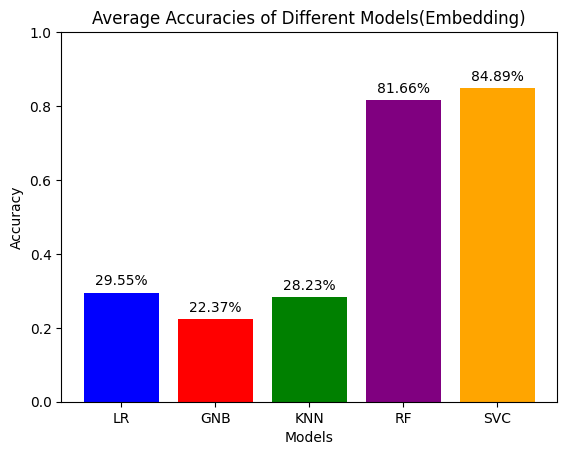

In [ ]:
# Print average accuracies
print("Average accuracies:")
print("Logistic Regression: ", avg_accuracy_embedding_lr)
print("Gaussian Naive Bayes: ", avg_accuracy_embedding_gnb)
print("K-Nearest Neighbors: ", avg_accuracy_embedding_knn)
print("Random Forest: ", avg_accuracy_embedding_rf)
print("Support Vector Machine: ", avg_accuracy_embedding_svc)

# Create a bar plot
models_str = ['LR', 'GNB', 'KNN', 'RF', 'SVC']
accuracies = [avg_accuracy_embedding_lr, avg_accuracy_embedding_gnb, avg_accuracy_embedding_knn, 
              avg_accuracy_embedding_rf, avg_accuracy_embedding_svc]
plt.bar(models_str, accuracies, color=['blue', 'red', 'green', 'purple', 'orange'])
plt.title('Average Accuracies of Different Models(Embedding)')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0,1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc+0.02, f"{acc*100:.2f}%", ha='center')
plt.show()

Define functions to test on valdiation dataset and get resutls on test dataset

In [ ]:
def test_prediction(model):
    y_pred = model.predict(X_valid_embedding)
    accuracy = accuracy_score(y_valid,y_pred)
    return accuracy


In [ ]:
# Initialize lists to store accuracy scores and model names
accuracies_valid = {'lr': [], 'gnb': [], 'knn': [], 'rf': [], 'svc': []}
for model_name, model_data in models_optimize.items():
        model = model_data['estimator']
        accuracies_valid[model_name].append(test_prediction(model))
        

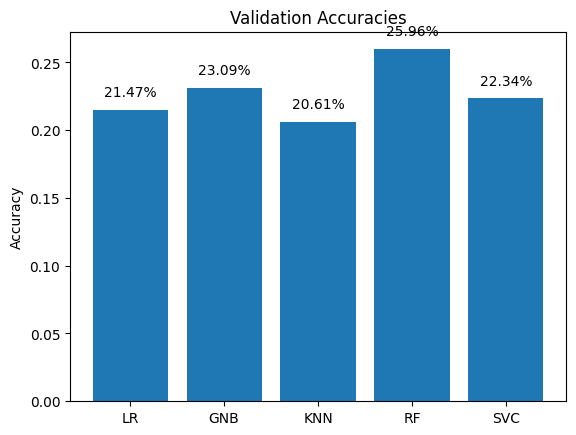

In [ ]:
# Define the x-axis labels
labels = ['LR', 'GNB', 'KNN', 'RF', 'SVC']

# Extract the validation accuracies for each model
accuracies = [accuracies_valid['lr'][0], accuracies_valid['gnb'][0], accuracies_valid['knn'][0], accuracies_valid['rf'][0], accuracies_valid['svc'][0]]

# Create a bar plot of the validation accuracies
fig, ax = plt.subplots()
ax.bar(labels, accuracies)
ax.set_ylabel('Accuracy')
ax.set_title('Validation Accuracies')

# Add the percentage values above each bar
for i, acc in enumerate(accuracies):
    ax.text(i, acc+0.01, f'{acc*100:.2f}%', ha='center', fontsize=10)

plt.show()


In [ ]:
def predict_test(model):
    y_pred = model.predict(X_test_embedding)
    results_df = pd.DataFrame({
    'job_id': raw_test_data['job_id'],
    'salary_bin': y_pred
    })
    results_df.to_csv('{}results.csv'.format(model), index=False)

In [ ]:
print(models_optimize['rf']['estimator'])
predict_test(models_optimize['rf']['estimator'])

RandomForestClassifier(max_depth=30, min_samples_leaf=8, n_estimators=200)


Define varaiables for active learning

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from scipy.stats import mode

models = { 'gnb': models_optimize['gnb']['estimator'], 'knn': models_optimize['knn']['estimator'], 'rf': models_optimize['rf']['estimator'], 'svc': models_optimize['svc']['estimator']}
unlabeled_preds = {model: [] for model in models}

# Split data into labeled and unlabeled sets
X_labeled, X_unlabeled, y_labeled, y_unlabeled = combined_train_data_X, unlabeled_embedded_raw_train_X, combined_train_data_y, unlabeled_train_data_y

# Choose a pool of unlabeled data to query from
X_pool = unlabeled_embedded_raw_train_X

batch_size = 1000

Active learning

In [ ]:
# Active learning loop
num_queries = int(len(X_unlabeled) / batch_size)
for i in range(num_queries):
    print(f"Query {i+1}/{num_queries}")
    
    # Compute committee disagreement for each batch of unlabeled data points
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    batch_X_pool = X_pool[start_idx:end_idx]
    disagreements = []

    for x in batch_X_pool:
        preds = []
        for modelName, model in models.items():
            preds.append(model.predict(x.reshape(1, -1))[0])
        disagreements.append(1 - mode(preds)[1] / len(models))
        
    # Select the top k unlabeled data points with the highest disagreement
    k = min(batch_size, len(X_pool))
    query_idxs = np.argsort(disagreements)[-k:]
    query_X = X_pool[query_idxs]

    query_X = query_X.reshape(batch_size*query_X.shape[1],query_X.shape[-1])
    
    query_preds = []
    for modelName, model in models.items():
        query_preds.append(model.predict(query_X))
    query_y = mode(np.vstack(query_preds))[0]
    
    # Add queried point to labeled data
    print("labeled data size before {} labeled training data y length before {}".format(X_labeled.shape[0], y_labeled.shape[0]))
    X_labeled = np.vstack((X_labeled, query_X))
    y_labeled = np.concatenate([y_labeled, np.squeeze(query_y)])
    print("labeled data size after {} labeled training data y length before {}".format(X_labeled.shape[0], y_labeled.shape[0]))
    
    # Remove queried point from unlabeled data pool
    X_pool = np.delete(X_pool, query_idxs, axis=0)
    
    # Re-train each model on the updated labeled data
    for modelName, model in models.items():
        model.fit(X_labeled, y_labeled)
    
    # Compute unlabeled predictions for each model on the updated unlabeled data pool
    for modelName, model in models.items():
        preds = model.predict(X_pool)
        unlabeled_preds[modelName].append(preds)

Query 1/5
labeled data size before 16000 labeled training data y length before 16000
labeled data size after 17000 labeled training data y length before 17000
Query 2/5
labeled data size before 17000 labeled training data y length before 17000
labeled data size after 18000 labeled training data y length before 18000
Query 3/5
labeled data size before 18000 labeled training data y length before 18000
labeled data size after 19000 labeled training data y length before 19000
Query 4/5
labeled data size before 19000 labeled training data y length before 19000
labeled data size after 20000 labeled training data y length before 20000
Query 5/5
labeled data size before 20000 labeled training data y length before 20000
labeled data size after 21000 labeled training data y length before 21000


In [ ]:
accuracies = {'lr': [], 'gnb': [], 'knn': [], 'rf': [], 'svc': []}

for i, (train_index, test_index) in enumerate(kf.split(X_labeled)):

    X_train, X_test = X_labeled[train_index], X_labeled[test_index]
    y_train, y_test = y_labeled[train_index], y_labeled[test_index]

    for modelName, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies[modelName].append(accuracy)


avg_accuracy_embedding_lr = np.mean(accuracies['lr'])
avg_accuracy_embedding_gnb = np.mean(accuracies['gnb'])
avg_accuracy_embedding_knn = np.mean(accuracies['knn'])
avg_accuracy_embedding_rf = np.mean(accuracies['rf'])
avg_accuracy_embedding_svc = np.mean(accuracies['svc'])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Average accuracies:
Logistic Regression:  nan
Gaussian Naive Bayes:  nan
K-Nearest Neighbors:  nan
Random Forest:  nan
Support Vector Machine:  0.648809523809524


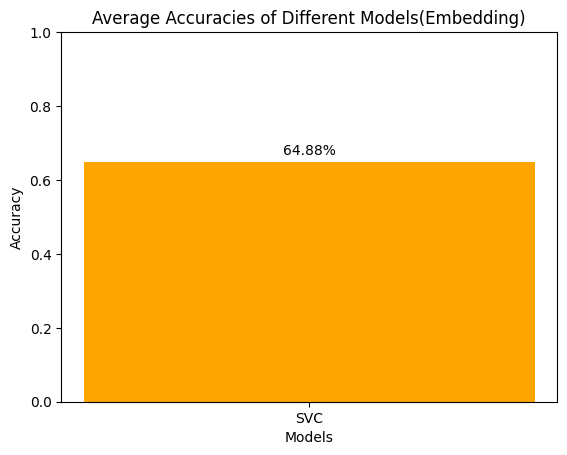

In [ ]:
# Print average accuracies
print("Average accuracies:")
print("Logistic Regression: ", avg_accuracy_embedding_lr)
print("Gaussian Naive Bayes: ", avg_accuracy_embedding_gnb)
print("K-Nearest Neighbors: ", avg_accuracy_embedding_knn)
print("Random Forest: ", avg_accuracy_embedding_rf)
print("Support Vector Machine: ", avg_accuracy_embedding_svc)

# Create a bar plot
models_str = ['LR', 'GNB', 'KNN', 'RF', 'SVC']
accuracies = [avg_accuracy_embedding_lr, avg_accuracy_embedding_gnb, avg_accuracy_embedding_knn, 
              avg_accuracy_embedding_rf, avg_accuracy_embedding_svc]
plt.bar(models_str, accuracies, color=['blue', 'red', 'green', 'purple', 'orange'])
plt.title('Average Accuracies of Different Models(Embedding)')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0,1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc+0.02, f"{acc*100:.2f}%", ha='center')
plt.show()